#### Agentic routing

In this use case, we "route" the LLM to different tasks based on ``type of query`` input, i.e. what task we want to accomplish.

It is also possible to "route" based on the input prompt, breaking down its complexity and figuring out (automatically) which task needs to be performed. This example does not show this use case.

In [1]:
import os
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
from typing import Literal, Annotated, Literal, Optional, TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as tool

import asyncio
import operator
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

In [2]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
class State(TypedDict):
    input: str
    type: Optional[Literal["write_article", "generate_table_of_contents", "review_article"]] = None
    output: Optional[str] = None


class MessageType(BaseModel):
    type: Literal["write_article", "generate_table_of_contents", "review_article"]

In [5]:
def classify_message(message: str) -> dict:
    model_with_str_output = model.with_structured_output(MessageType)
    messages = [
        SystemMessage(
            content=f"""You are a writer. You will classify the message into one of the following categories:
                  'write_article', 'generate_table_of_contents', 'review_article'."""
        ),
        HumanMessage(content=f"Classify the message: {message}"),
    ]
    return {"type": model_with_str_output.invoke(messages).type}


def route_message(state: State) -> State:
    if state["type"] == "write_article":
        return "generate_article_content"
    elif state["type"] == "generate_table_of_contents":
        return "generate_table_of_contents"
    elif state["type"] == "review_article":
        return "revise_article_content"
    else:
        raise ValueError(f"Invalid message type: {state['type']}")


def generate_table_of_contents(state: State) -> State:
    messages = [
        SystemMessage(
            content=f"""You are an expert writer specialized in SEO. Provided with a topic, 
            you will generate the table of contents for a short article."""
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of the following article:\n\n{state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}

In [ ]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("classify_message", classify_message)
workflow_builder.add_node("generate_table_of_contents", generate_table_of_contents)
workflow_builder.add_node("generate_article_content", generate_article_content)
workflow_builder.add_node("revise_article_content", revise_article_content)
# edges now
workflow_builder.add_edge(START, "classify_message")

# which edge to go to next based on router message
workflow_builder.add_conditional_edges(
    source = "classify_message",
    path = route_message,
    path_map = {
        "generate_article_content": "generate_article_content",
        "generate_table_of_contents": "generate_table_of_contents",
        "revise_article_content": "revise_article_content",
    },
)
workflow_builder.add_edge("generate_table_of_contents", END)
workflow_builder.add_edge("generate_article_content", END)
workflow_builder.add_edge("revise_article_content", END)

workflow = workflow_builder.compile()

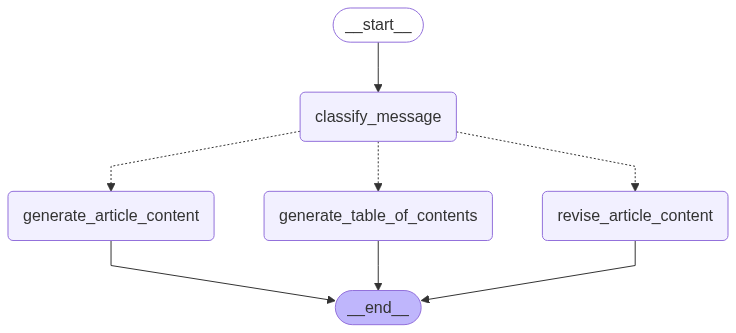

In [11]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [13]:
article = workflow.invoke({"input": "write an article about Quantum Computing"})

In [14]:
print(article)

{'input': 'write an article about Quantum Computing', 'type': 'write_article', 'output': '# Quantum Computing: Revolutionizing the Future of Technology\n\nQuantum computing is an emerging field at the intersection of computer science, physics, and mathematics that promises to revolutionize the way we process information. Unlike classical computers, which use bits as the smallest unit of data, quantum computers leverage quantum bits or qubits, enabling them to perform complex calculations at unprecedented speeds. This article explores the fundamentals of quantum computing, its potential applications, challenges, and the future outlook of this transformative technology.\n\n## What is Quantum Computing?\n\nQuantum computing is a type of computation that harnesses the principles of quantum mechanics to process information. Traditional computers operate using bits that represent either a 0 or a 1. In contrast, quantum computers use qubits, which can exist simultaneously in multiple states t